In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

# Datasets

## IM-Fusion

In [2]:
# Read RNA CTGs.
rna_ctgs = (pd.read_csv('../data/processed/sanger/star/ctgs.txt', sep='\t')
              .sort_values(['p_value']))

# Read RNA insertions.
insertions_rna = (pd.read_csv('../data/processed/sanger/star/insertions.txt', sep='\t')
                    .query('support >= 10'))

## Sanger DNA-seq

In [3]:
# Read DNA CTGs.
dna_hits = (pd.read_excel('../data/external/sanger/publication/'
                          'WTSI_DJA_TAPJ_TA_PAX_ONC_B220PLUS_CD19PLUS_CIS_MERGER.xlsx')
              .rename(columns={
                 'Gene': 'gene_name',
                 'Number of Tumours in CIS': 'n_samples'
              })
              .get(['gene_name', 'n_samples'])
              .drop_duplicates())

dna_hits.head()

,gene_name,n_samples
0,CIS7:37319336_15k,14
1,Ophn1,11
2,Jak1,10
3,CIS7:143203112_120k,9
4,Kit,8


In [4]:
from imfusion.model import Insertion
from nbsupport import util, insertions as nb_ins


def _insertions_from_sanger_bed(bed_data):
    """Converts Sanger bed format into an insertion DataFrame."""
    
    name_info = bed_data['name'].str.extract(
        r'_(?P<sample>TAP[\w-]+)\.', expand=True)
    
    col_order = ['id', 'seqname', 'position', 'strand',
                 'support_junction', 'support_spanning',
                 'support', 'sample']
    
    return pd.DataFrame({
        'id': ['INS_{}'.format(i + 1) 
               for i in range(len(bed_data))],
        'seqname': bed_data['chrom'].str.replace('chr', ''),
        'position': bed_data['chromStart'],
        'strand': bed_data['strand'].map({'-': -1, '+': 1}),
        'support_junction': bed_data['score'],
        'support_spanning': 0,
        'support': bed_data['score'],
        'sample': name_info['sample']
    }, columns=col_order)


# Read insertions from Sanger bed file.
bed_path = ('../data/external/sanger/publication/TAPJ/JANUARY_2015_FILE_TRANFSER/'
            'WTSI_DJA_TAPJ_20130328_TA_PAX_ONC_B220+_CD19+_INSERTIONS_DEFIRESTORMED.bed')

insertions_dna = (util.read_bed(bed_path)
                      .pipe(_insertions_from_sanger_bed))

# Annotate insertions with mm9 genes. Here we assign insertions to genes 
# within 20kb window and then restrict annotation to closest gene.
genes_mm9 = util.fetch_biomart_genes_mm9()

insertion_objs = Insertion.from_frame(insertions_dna)
annotated_objs = nb_ins.annotate_insertions(
    insertion_objs, window=20000, genes=genes_mm9, select_closest=True)

insertions_dna = Insertion.to_frame(annotated_objs)
insertions_dna.head()

,id,seqname,position,strand,support_junction,support_spanning,support,gene_distance,gene_id,gene_name,sample
0,INS_1,7,76004135,-1,9,0,9,NaN,NaN,NaN,TAPJ49-1a
1,INS_2,7,116931954,1,6,0,6,6415.0,ENSMUSG00000034825,Nrip3,TAPJ49-1a
2,INS_3,7,130823505,1,4,0,4,NaN,NaN,NaN,TAPJ49-1a
3,INS_4,14,15533200,-1,3,0,3,2339.0,ENSMUSG00000021733,Slc4a7,TAPJ49-1a
4,INS_5,14,17511791,1,1,0,1,0.0,ENSMUSG00000017491,Rarb,TAPJ49-1a


In [5]:
# Quick sanity check, to see if the expected hits are among the top genes.
(insertions_dna.groupby(['gene_id', 'gene_name'])
               ['sample'].nunique()
               .sort_values(ascending=False)
               .head(n=10))

gene_id             gene_name
ENSMUSG00000092329  Gm20388      12
ENSMUSG00000056899  Immp2l       11
ENSMUSG00000030849  Fgfr2        11
ENSMUSG00000028530  Jak1         10
ENSMUSG00000021699  Pde4d         9
ENSMUSG00000068205  Macrod2       9
ENSMUSG00000020919  Stat5b        8
ENSMUSG00000030067  Foxp1         8
ENSMUSG00000022708  Zbtb20        8
ENSMUSG00000041654  Slc39a11      7
Name: sample, dtype: int64

# Rank comparison

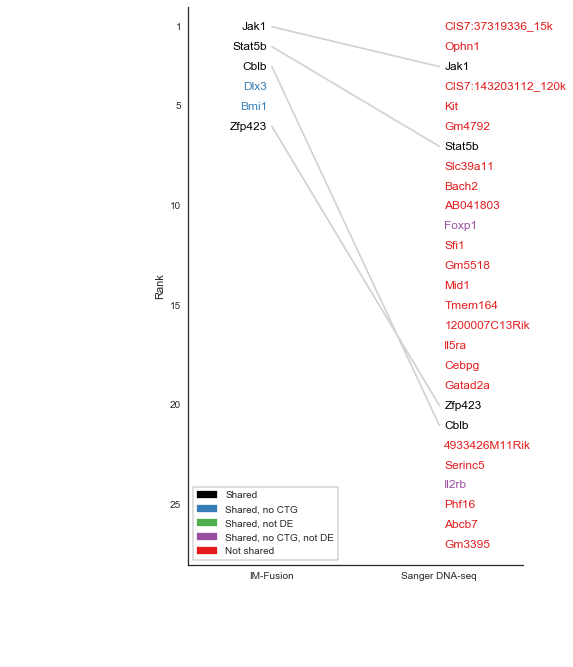

In [6]:
import toolz

from nbsupport import rank
from imfusion.expression import read_exon_counts

# TODO: compare shared with filtered or unfiltered insertions? 
# TODO: DE based on IM-Fusion insertions or on Sanger analysis?

# Read counts and create gene_id --> gene_name map needed for annotate_de.
exon_counts = read_exon_counts('../data/processed/sanger/star/expression.txt')

gene_id_map = toolz.merge(
     dict(zip(insertions_dna['gene_name'], insertions_dna['gene_id'])),
     dict(zip(insertions_rna['gene_name'], insertions_rna['gene_id'])))

# Compare and annotate rankings.
ranks = (
    rank.compare_ranks(rna_ctgs.query('de_pvalue <= 0.05'), dna_hits,
                       suffixes=('_rna', '_dna'))
        .pipe(rank.annotate_ctg, ctgs=rna_ctgs, col_name='ctg_rna')
        .pipe(rank.annotate_ctg, ctgs=dna_hits, col_name='ctg_dna')
        .pipe(rank.annotate_ins, insertions=insertions_rna, col_name='ins_rna')
        .pipe(rank.annotate_ins, insertions=insertions_dna, col_name='ins_dna')
        .pipe(rank.annotate_de, insertions=insertions_rna, 
              exon_counts=exon_counts, gene_id_map=gene_id_map,
              col_name='is_de')
        .pipe(rank.annotate_type))
    
# Plot ranking.
order = rank.RANK_TYPES
palette = (['black'] + sns.color_palette('Set1')[1:4] + 
           [sns.color_palette('Set1')[0]])

fig, ax = plt.subplots(figsize=(6, 10)) 
rank.plot_ranks(ranks, rank_a='rank_rna', rank_b='rank_dna',
                label='gene_name', hue='type', ax=ax,
                palette=palette, order=order,
                legend_kws={'frameon': True, 
                            'loc': 'lower left'}) 
ax.set_xticklabels(['IM-Fusion', 'Sanger DNA-seq']); 

# Single vs paired-end

In [7]:
rna_ctgs_single = pd.read_csv('../data/processed/sanger/star-single/ctgs.txt', sep='\t')
rna_ctgs_single

,gene_id,gene_name,p_value,q_value,n_samples,de_pvalue,de_direction,de_test
0,ENSMUSG00000028530,Jak1,2.550840e-19,1.428470e-17,7,0.000328,1,exon
1,ENSMUSG00000020919,Stat5b,1.408681e-14,7.888615e-13,5,0.000620,1,exon
2,ENSMUSG00000022637,Cblb,2.116503e-12,1.185242e-10,5,0.000620,-1,exon
3,ENSMUSG00000001510,Dlx3,1.086529e-06,6.084565e-05,2,0.010375,1,exon
4,ENSMUSG00000004043,Stat5a,3.006863e-06,1.683843e-04,2,0.092938,-1,exon
5,ENSMUSG00000026739,Bmi1,3.242743e-06,1.815936e-04,2,0.013734,1,exon
6,ENSMUSG00000024241,Sos1,2.171508e-05,1.216044e-03,2,0.285375,-1,exon
7,ENSMUSG00000045333,Zfp423,8.086889e-05,4.528658e-03,2,0.013734,1,exon
8,ENSMUSG00000030068,Gm20696,2.077424e-04,1.163357e-02,2,0.500000,-1,exon
9,ENSMUSG00000030067,Foxp1,4.317958e-04,2.418056e-02,2,0.206415,1,exon


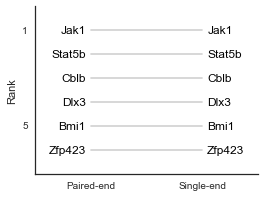

In [8]:
ranks_single = rank.compare_ranks( 
    rna_ctgs.query('de_pvalue < 0.05'),
    rna_ctgs_single.query('de_pvalue < 0.05'),
    suffixes=('_paired', '_single'))

fig, ax = plt.subplots(figsize=(4, 3))
rank.plot_ranks(ranks_single, rank_a='rank_paired', ax=ax,
                rank_b='rank_single', label='gene_name')
ax.set_xticklabels(['Paired-end', 'Single-end']);

In [9]:
# Check number of samples per gene.
pd.merge(rna_ctgs[['gene_name', 'n_samples']],
         rna_ctgs_single[['gene_name', 'n_samples']],
         on='gene_name', suffixes=['_paired', '_single'])

,gene_name,n_samples_paired,n_samples_single
0,Jak1,9,7
1,Stat5b,7,5
2,Cblb,5,5
3,Dlx3,2,2
4,Stat5a,2,2
5,Bmi1,2,2
6,Sos1,2,2
7,Zfp423,2,2
8,Gm20696,2,2


In [17]:
(insertions_paired
 .groupby(['sample', 'gene_name'])
 ['support', 'support_junction', 'support_spanning'].max()
 .rename(columns=lambda c: 'paired_' + c)
 .reset_index())

,sample,gene_name,paired_support,paired_support_junction,paired_support_spanning
0,TAPJ102_5c,2310035C23Rik,1,1,0
1,TAPJ102_5c,4833420G17Rik,1,1,0
2,TAPJ102_5c,4930523C07Rik,1,1,0
3,TAPJ102_5c,Actr3,1,1,0
4,TAPJ102_5c,Adss,1,1,0
5,TAPJ102_5c,Aff4,1,1,0
6,TAPJ102_5c,Agtpbp1,1,1,0
7,TAPJ102_5c,Akap13,1,1,0
8,TAPJ102_5c,Arhgap15,1,1,0
9,TAPJ102_5c,Arih1,1,1,0


In [56]:
insertions_paired = pd.read_csv('../data/processed/sanger/star/insertions.txt', sep='\t')
insertions_single = pd.read_csv('../data/processed/sanger/star-single/insertions.txt', sep='\t')

paired_summ = (
     insertions_paired
     .query('support >= 10')
     .groupby(['sample', 'gene_name'])
     ['support', 'support_junction', 'support_spanning'].max()
     .rename(columns=lambda c: 'paired_' + c)
     .reset_index())

single_summ = (
    insertions_single
    .query('support >= 10')
    .groupby(['sample', 'gene_name'])
    ['support'].max()
    .to_frame('single_support')
    .reset_index())

merged_summ = (
    pd.merge(single_summ, paired_summ, 
          on=['sample', 'gene_name'], how='outer')
   .query('gene_name == {!r}'.format(list(ranks_single['gene_name'])))
   .sort_values(['gene_name', 'paired_support'], ascending=[True, False]))

merged_summ['ratio_single'] = merged_summ['paired_support'] / merged_summ['single_support']
merged_summ['ratio_paired_junction'] = (
    merged_summ['paired_support_junction'] / 
    (merged_summ['paired_support_spanning']))

merged_summ.head()

,sample,gene_name,single_support,paired_support,paired_support_junction,paired_support_spanning,ratio_single,ratio_paired_junction
38,TAPJ49_5c,Bmi1,443.0,1714.0,1714.0,191.0,3.869074,8.973822
79,TAPJ64_3d,Bmi1,226.0,549.0,548.0,1.0,2.429204,548.000000
62,TAPJ53_3m,Cblb,761.0,1286.0,1029.0,257.0,1.689882,4.003891
102,TAPJ84_3c,Cblb,374.0,670.0,523.0,147.0,1.791444,3.557823
39,TAPJ49_5c,Cblb,334.0,651.0,515.0,136.0,1.949102,3.786765


In [57]:
merged_summ['ratio_single'].describe()

count    23.000000
mean      4.223114
std       4.714690
min       1.051724
25%       1.700679
50%       2.091912
75%       5.114165
max      22.222222
Name: ratio_single, dtype: float64

In [61]:
merged_summ['ratio_paired_junction'].describe()

/home/NFS/users/j.d.ruiter/.anaconda3/envs/imfusion/lib/python3.5/site-packages/numpy/lib/function_base.py:3817: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


count    27.000000
mean           inf
std            NaN
min       2.133333
25%       6.488857
50%            NaN
75%            inf
max            inf
Name: ratio_paired_junction, dtype: float64

In [68]:
from io import StringIO

buf = StringIO()
(merged_summ.drop(['ratio_single', 'ratio_paired_junction'], axis=1)
            .rename(columns=lambda c: c.replace('_', ' ').capitalize())
            .to_latex(buf, index=False))
print(buf.getvalue())

\begin{tabular}{llrrrr}
\toprule
     Sample & Gene name &  Single support &  Paired support &  Paired support junction &  Paired support spanning \\
\midrule
  TAPJ49\_5c &      Bmi1 &           443.0 &          1714.0 &                   1714.0 &                    191.0 \\
  TAPJ64\_3d &      Bmi1 &           226.0 &           549.0 &                    548.0 &                      1.0 \\
  TAPJ53\_3m &      Cblb &           761.0 &          1286.0 &                   1029.0 &                    257.0 \\
  TAPJ84\_3c &      Cblb &           374.0 &           670.0 &                    523.0 &                    147.0 \\
  TAPJ49\_5c &      Cblb &           334.0 &           651.0 &                    515.0 &                    136.0 \\
  TAPJ52\_2a &      Cblb &           272.0 &           569.0 &                    441.0 &                    128.0 \\
 TAPJ102\_5c &      Cblb &           232.0 &           498.0 &                    380.0 &                    118.0 \\
  TAPJ53\_3m & 